# Load Modules and File Paths

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
from os.path import abspath
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams['text.latex.unicode']=False
import datetime
from operator import add
import pickle
from sklearn.impute import SimpleImputer as Imputer
from osgeo import gdal
import xarray as xr
from affine import Affine
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

imp = Imputer(strategy='mean')

# --------------------- #
# Lets Rips Some Treads #
# --------------------- #

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()


if abspath('../utils/') not in sys.path:
    sys.path.append(abspath('../utils/'))
# from utils import GetExtent

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
SITENAME = 'tuolumne'
name = 'snowdepth'
formato = 'netcdf'
YEAR = '2015'
path_to_data = f'/srv/shared/deep_stac/data/{name}/{formato}/{YEAR}'
path_to_topo = '/srv/shared/deep_stac/data/topo.nc'
files = os.listdir(path_to_data)
files = np.sort([f for f in files if 'int' in f])
## make cell of filenames with paths
fname_list = [os.path.join(path_to_data, f) for f in np.sort(files)]
dates = [pd.to_datetime(d.split('_')[0]).date() for d in files]

### Read in Topo Data new way

In [5]:
## start by opening and cleaning up netcdf 
datadtopo = xr.open_dataset(path_to_topo, chunks={'x':1000, 'y':1000})

## cleanup
add_to_lidar = ['dem','veg_height','mask']
## dtopo is the dataset with only the desired variables
dtopo = datadtopo[add_to_lidar]
print(dtopo)


<xarray.Dataset>
Dimensions:     (x: 17569, y: 17002)
Coordinates:
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
Data variables:
    dem         (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg_height  (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    mask        (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
    generation_command:  /usr/local/bin/basin_setup -f corrected_tuolumne_sub...


### Read in Lidar Data new way

In [97]:
ds0 = xr.open_mfdataset(fname_list[0], chunks={'x':1000, 'y':1000})
ds1 = xr.open_mfdataset(fname_list[1], chunks={'x':1000, 'y':1000})
ds0 = ds0.drop('transverse_mercator')
ds1 = ds1.drop('transverse_mercator')

#rename variable in ds1
ds1['Band2'] = ds1['Band1']
ds1 = ds1.drop(['Band1'])
print(ds0)

<xarray.Dataset>
Dimensions:  (x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Data variables:
    Band1    (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:42:33 2019: GDAL CreateCopy( /srv/shar...


In [87]:
print(ds1)

<xarray.Dataset>
Dimensions:  (x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Data variables:
    Band1    (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:40:43 2019: GDAL CreateCopy( /srv/shar...


xarray.core.dataset.Dataset

In [98]:
new=xr.merge([ds0,ds1])
new

<xarray.Dataset>
Dimensions:  (x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Data variables:
    Band1    (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    Band2    (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>

In [88]:
type(ds1)

xarray.core.dataset.Dataset

In [99]:
# --------------- #
# Read Lidar Data #
# --------------- #
ds = xr.open_mfdataset(fname_list, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
ds.close()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)


In [73]:
fname_list

['/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150218_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150306_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150325_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150403_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150409_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150415_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150427_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150501_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150528_SUPERsnow_depth_3m_int.nc',
 '/srv/shared/deep_stac/data/snowdepth/netcdf/2015/20150608_SUPERsnow_depth_3m_int.nc']

### Read in Lidar and Topo Data old way

In [3]:
# --------------- #
# Read Lidar Data #
# --------------- #
ds = xr.open_mfdataset(fname_list, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
ds.close()

dtopo = xr.open_dataset(path_to_topo, chunks={'x':1000, 'y':1000})
dtopo.close()


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)


In [4]:
ds

<xarray.Dataset>
Dimensions:              (flight_date: 10, x: 17569, y: 17002)
Coordinates:
  * x                    (x) float64 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y                    (y) float64 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Dimensions without coordinates: flight_date
Data variables:
    transverse_mercator  (flight_date) |S1 b'' b'' b'' b'' ... b'' b'' b'' b''
    Band1                (flight_date, y, x) float32 dask.array<shape=(10, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:42:33 2019: GDAL CreateCopy( /srv/shar...

### Sub select features to include to the dem. 

In [54]:
add_to_lidar = ['dem','veg_height','mask']
## dtopo is the dataset with only the desired variables
dtopo = dtopo[add_to_lidar]

In [61]:
# -------------------- #
# Remove These features #
# -------------------- #

ds = ds.drop('transverse_mercator')

dtopo = dtopo.expand_dims('flight_date')

dtopo
ds

ValueError: One or more of the specified variables cannot be found in this dataset

In [63]:

print(ds)

<xarray.Dataset>
Dimensions:  (flight_date: 10, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Dimensions without coordinates: flight_date
Data variables:
    Band1    (flight_date, y, x) float32 dask.array<shape=(10, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:42:33 2019: GDAL CreateCopy( /srv/shar...


### Print Data Details

In [7]:
print('TOPO: \n\n',dtopo, '\n\n\nLidar:\n\n', ds)

TOPO: 

 <xarray.Dataset>
Dimensions:     (flight_date: 1, x: 17569, y: 17002)
Coordinates:
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
Dimensions without coordinates: flight_date
Data variables:
    dem         (flight_date, y, x) float32 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
    veg_height  (flight_date, y, x) float32 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
    mask        (flight_date, y, x) uint8 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
  

In [8]:
ds['date'] = (['date'], dates)
ds = ds.assign_coords(date=ds.date)
vd = ds.Band1.std(dim='flight_date')

vd = np.where(vd > 0.01, vd, np.nan)

NameError: name 'im' is not defined

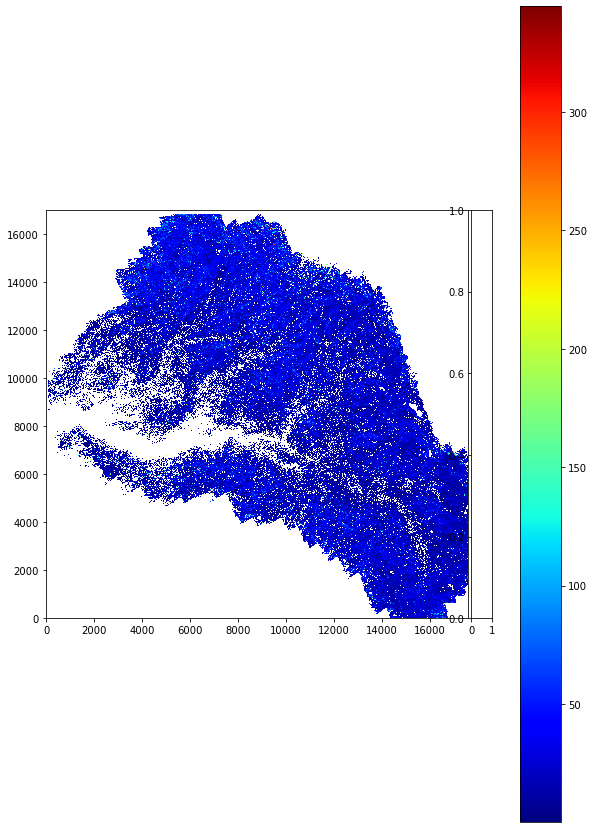

In [9]:
plt.figure(figsize=(10,15))
ax = plt.subplot(1,1,1)
plt.imshow(vd, origin='lower', cmap='jet')#, vmin=1, vmax=200.0)
plt.colorbar()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [ ]:
chks = []

for chk in chks:
    chk = range(0:1000) +_____
    chks.append(chk)

In [ ]:
boo = DS['Band1'][4,10000:14000,10000:14000]

In [ ]:
boo.plot()

In [ ]:
import sys
print(boo.nbytes/1000000)